In [1]:
%matplotlib inline
import calendar
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re

### Funkcja zwracająca długość dnia w godzinach dla n-tego dnia roku

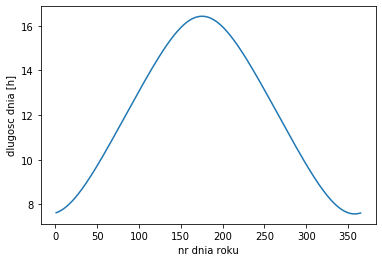

In [2]:
def dlugosc_dnia(numer_dnia):
    
    phi = 23. * np.pi/180. * np.cos(2.*np.pi * (numer_dnia+7.) / 365.)
    result = 24. / np.pi * np.arccos(np.tan(52.23 * np.pi/180.) * np.tan(phi))
    return round(result, 3)


plt.plot(range(1,366), [dlugosc_dnia(x) for x in range(1,366)])
plt.xlabel('nr dnia roku')
plt.ylabel('dlugosc dnia [h]')
plt.show()

### Wczytaj dane pogodowe ze wszystkich miesiecy i polacz w jedną tablicę.
+ dla stacji pogodowej "WARSZAWA-BIELANY".

In [3]:
dane = pd.DataFrame()

# Wczytaj dane pogodowe
#
for i in range( 1, 13):
    
    df = pd.read_csv("./input/pogoda 2018/k_d_t_{:0>2d}_2018.csv".format(i), encoding = "latin")
    
    df.columns = ['Kod stacji','Nazwa stacji','Rok','Miesiac','Dzien','Temperatura','-','Wilgotnosc',\
     '-','Wiatr','-','Zachmurzenie','Status']

    df = df[df['Nazwa stacji'].str.contains("WARSZAWA-BIELANY")]
    df = df.loc[:, ['Nazwa stacji','Miesiac','Dzien','Temperatura','Wilgotnosc','Wiatr','Zachmurzenie']]

    dane = pd.concat( [dane, df])

    
# Dodaj kolumnę z numerem dnia roku
#
dane.insert(3, "Dzien_roku", range( 1, 366), True)
dane = dane.reset_index().drop(columns = 'index')


# Dodaj kolumnę z dlugością dnia w godzinach
#
dane.insert(8, "Dlugosc_dnia", dlugosc_dnia(dane['Dzien_roku']), True)

dane.iloc[0:10]

,Nazwa stacji,Miesiac,Dzien,Dzien_roku,Temperatura,Wilgotnosc,Wiatr,Zachmurzenie,Dlugosc_dnia
0,WARSZAWA-BIELANY,1,1,1,7.2,79.0,2.3,7.7,7.624
1,WARSZAWA-BIELANY,1,2,2,2.6,95.5,2.3,2.7,7.638
2,WARSZAWA-BIELANY,1,3,3,3.6,87.8,3.7,6.7,7.653
3,WARSZAWA-BIELANY,1,4,4,5.4,79.5,3.7,7.7,7.670
4,WARSZAWA-BIELANY,1,5,5,6.0,78.8,4.0,6.0,7.689
5,WARSZAWA-BIELANY,1,6,6,6.3,88.5,2.7,4.7,7.709
6,WARSZAWA-BIELANY,1,7,7,1.8,83.0,2.0,6.7,7.730
7,WARSZAWA-BIELANY,1,8,8,-3.5,81.0,1.0,0.0,7.754
8,WARSZAWA-BIELANY,1,9,9,-2.0,80.5,4.3,1.3,7.778
9,WARSZAWA-BIELANY,1,10,10,0.4,73.5,3.3,6.3,7.804


### Wczytaj dane o cisnieniu i opadzie dobowym

In [4]:
# Wczytaj tablicę z ciśnieniem
#
df = pd.read_csv("./input/cisnienie 2018/s_d_t_375_2018.csv")

df.columns = ['Kod stacji','Miasta','Rok','Miesiac','Dzien','Zachmurzenie','-','Cisnienie pary wodnej',\
     '-','Temp srednia','-','Temp max','-','Wilgotnosc','-','Cisnienie stacja','-','Cisnienie morze','-',\
     'Opad dzien','-','Opad noc','-']

df = df.loc[:, ['Dzien','Temp srednia','Cisnienie stacja','Cisnienie morze','Opad dzien','Opad noc']]

dane['Cisnienie'] = df['Cisnienie stacja']
dane['Opad'] = df['Opad dzien'] + df['Opad noc']

dane.tail()

,Nazwa stacji,Miesiac,Dzien,Dzien_roku,Temperatura,Wilgotnosc,Wiatr,Zachmurzenie,Dlugosc_dnia,Cisnienie,Opad
360,WARSZAWA-BIELANY,12,27,361,4.7,93.5,3.0,8.0,7.578,1005.8,2.5
361,WARSZAWA-BIELANY,12,28,362,5.8,87.0,3.7,7.3,7.584,1004.6,0.9
362,WARSZAWA-BIELANY,12,29,363,4.4,85.8,2.0,8.0,7.592,1009.6,0.9
363,WARSZAWA-BIELANY,12,30,364,4.9,94.5,2.3,8.0,7.601,1003.9,4.2
364,WARSZAWA-BIELANY,12,31,365,3.6,81.0,3.3,6.7,7.611,1011.2,0.0


### Zachmurzenie jako histogram

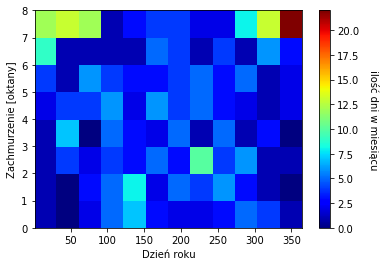

In [5]:
x = dane['Dzien_roku'].to_list()
y = dane['Zachmurzenie'].to_list()

plt.hist2d(x, y, bins=(12, 8), cmap=plt.cm.jet)
cbar = plt.colorbar()
cbar.ax.set_ylabel('ilość dni w miesiącu', labelpad=20, rotation=270)

plt.xlabel("Dzień roku")
plt.ylabel("Zachmurzenie [oktany]")
plt.savefig("output/wykresy roczne/Zachmurzenie.png")

### Temperatura i wilgotnosc - wykresy

In [6]:
# Funkcja rysująca wykres i zapisująca go do pliku. Niejako dekorator metody plt.plot(...)
#
def plot_and_save(dane, x_, y_, path=None, kind='line'):
    
    dane.plot( x = x_, y = y_, kind = kind)
    
    plt.xlabel(titles_[x_])
    plt.ylabel(titles_[y_])
    
    # Jeśli w nazwie `path` jest '(zima)'|'(lato)'|'(rok)' to wypisz to słowo jako legendę
    #
    if path:
        plt.legend(re.findall('\((.+)\)', path))
        plt.savefig(path)
        
        
# Powiąż odpowiednie kolumny zbioru danych z odpowiadającymi tytułami osi na wykresach
#
keys_ = dane.columns.tolist() + ['PM2.5','PM10','O3']
values_ = ['Nazwa stacji','Miesiąc','Dzień','Dzień roku','Temperatura [°C]','Wilgotność [%]'
           ,'Wiatr $[m/s]$', 'Zachmurzenie [oktany]','Długość dnia [h]','Ciśnienie [hPa]','Opad [mm/dzień]'
           ,'PM2.5 $[\mu g/m^3]$','PM10 $[\mu g/m^3]$','O3 $[\mu g/m^3]$']

titles_ = dict(zip(keys_,values_))

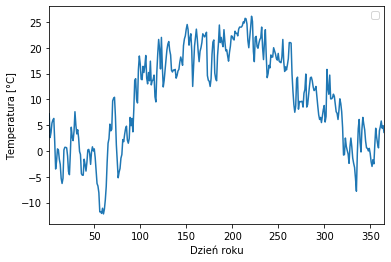

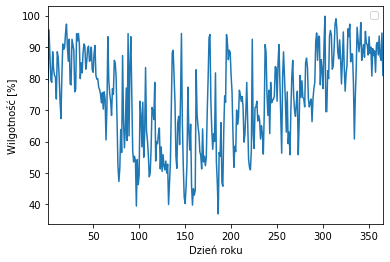

In [7]:
plot_and_save(dane, 'Dzien_roku', 'Temperatura', 'output/wykresy roczne/Temperatura.png')
plot_and_save(dane, 'Dzien_roku', 'Wilgotnosc', 'output/wykresy roczne/Wilgotnosc.png')

### Wczytaj dane o zanieczyszczeniu PM2.5/PM10/O3 z wybranej stacji pomiaru smogu.
+ PM2.5 i PM10 - stacja '`MzWarTolstoj`'
+ O3 - stacja '`MzPiasPulask`'

In [8]:
def wczytaj( stacja, zwiazek):
    
    df = pd.read_csv("./input/zanieczyszczenie 2018/2018_{}_1g.csv".format(zwiazek), skiprows=5, decimal = ',')

    # Uśredniając, zamień dane godzinne na dniowe
    #
    list_hour = df['{}-{}-1g'.format(stacja,zwiazek)].to_list()
    list_day = []

    for i in range( 0, len(list_hour), 24):
        list_day.append( np.mean( list_hour[i:i+24]))

    df = pd.DataFrame( list_day, columns=['{}'.format(zwiazek)])
    return df


dane_rok = pd.concat( [dane, wczytaj("MzWarTolstoj","PM2.5"), wczytaj("MzWarTolstoj","PM10"),\
                     wczytaj("MzPiasPulask","O3")], axis = 1)
dane_rok.head()

,Nazwa stacji,Miesiac,Dzien,Dzien_roku,Temperatura,Wilgotnosc,Wiatr,Zachmurzenie,Dlugosc_dnia,Cisnienie,Opad,PM2.5,PM10,O3
0,WARSZAWA-BIELANY,1,1,1,7.2,79.0,2.3,7.7,7.624,991.6,0.0,20.577083,24.401250,34.604413
1,WARSZAWA-BIELANY,1,2,2,2.6,95.5,2.3,2.7,7.638,994.5,0.0,34.447083,41.503333,10.554754
2,WARSZAWA-BIELANY,1,3,3,3.6,87.8,3.7,6.7,7.653,987.3,2.4,16.780000,19.558333,38.990617
3,WARSZAWA-BIELANY,1,4,4,5.4,79.5,3.7,7.7,7.670,984.0,0.2,11.202917,12.926250,47.200938
4,WARSZAWA-BIELANY,1,5,5,6.0,78.8,4.0,6.0,7.689,986.0,0.2,13.802917,16.261250,41.013171


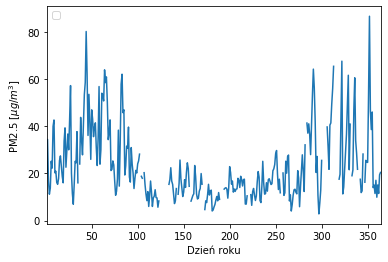

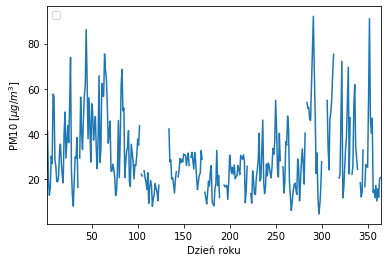

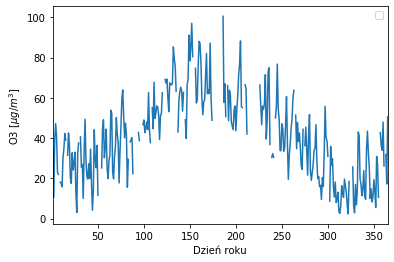

In [9]:
plot_and_save(dane_rok, 'Dzien_roku', 'PM2.5', 'output/wykresy roczne/PM2.5.png')
plot_and_save(dane_rok, 'Dzien_roku', 'PM10', 'output/wykresy roczne/PM10.png')
plot_and_save(dane_rok, 'Dzien_roku', 'O3', 'output/wykresy roczne/O3.png')

### Podziel zbiór danych na 2 części:
+ sezon grzewczy ('zima') od początku października (2018) do końca marca (2018)
+ sezon letni ('lato') - reszta roku

In [10]:
sezon_slm = dane_rok[ dane_rok['Miesiac'] <= 3 ]  # styczen, luty, marzec
sezon_plg = dane_rok[ dane_rok['Miesiac'] >= 10]  # pazdziernik, listopad, grudzien
lato = dane_rok[(dane_rok['Miesiac'] > 3) & (dane_rok['Miesiac'] < 10)]  # reszta roku

dane_zima = pd.concat([sezon_slm, sezon_plg]).drop( columns = 'Dzien_roku')
dane_lato = pd.concat([lato]).drop( columns = 'Dzien_roku')


dane_zima.insert(3, "Dzien_zimy", range( 1, 183), True)
dane_lato.insert(3, "Dzien_lata", range( 1, 184), True)

### Wypisz korelacje, oddzielnie dla każdej z 2 części zbioru danych oraz dla całości

+ Zima

In [11]:
corr = dane_zima.corr()
corr.style.background_gradient(cmap='coolwarm')

,Miesiac,Dzien,Dzien_zimy,Temperatura,Wilgotnosc,Wiatr,Zachmurzenie,Dlugosc_dnia,Cisnienie,Opad,PM2.5,PM10,O3
Miesiac,1,0.0169955,0.936814,0.434132,0.235844,-0.0318105,-0.0022428,-0.219878,0.21808,0.112166,-0.0698182,-0.0748046,-0.312651
Dzien,0.0169955,1,0.181555,-0.122308,-0.0706214,0.160712,0.104057,0.0247655,0.144911,0.159172,-0.119041,-0.139497,0.133495
Dzien_zimy,0.936814,0.181555,1,0.265808,0.174885,-0.0101191,0.066581,-0.173182,0.161325,0.114986,-0.025743,-0.072878,-0.24689
Temperatura,0.434132,-0.122308,0.265808,1,0.0512205,-0.0475158,-0.0185284,0.200102,-0.155089,0.0895498,-0.133504,-0.0607122,-0.115424
Wilgotnosc,0.235844,-0.0706214,0.174885,0.0512205,1,-0.201382,0.567766,-0.545719,0.00406094,0.253948,0.061932,0.0028658,-0.615505
Wiatr,-0.0318105,0.160712,-0.0101191,-0.0475158,-0.201382,1,0.0496532,-0.162687,-0.165178,0.182427,-0.532314,-0.54284,0.533226
Zachmurzenie,-0.0022428,0.104057,0.066581,-0.0185284,0.567766,0.0496532,1,-0.317713,-0.302477,0.275481,-0.0952842,-0.19151,-0.206647
Dlugosc_dnia,-0.219878,0.0247655,-0.173182,0.200102,-0.545719,-0.162687,-0.317713,1,-0.15032,-0.0542849,0.135178,0.163108,0.321201
Cisnienie,0.21808,0.144911,0.161325,-0.155089,0.00406094,-0.165178,-0.302477,-0.15032,1,-0.253807,0.0935554,0.136333,-0.25245
Opad,0.112166,0.159172,0.114986,0.0895498,0.253948,0.182427,0.275481,-0.0542849,-0.253807,1,-0.177998,-0.206137,0.0114223


+ Lato

In [12]:
corr = dane_lato.corr()
corr.style.background_gradient(cmap='coolwarm')

,Miesiac,Dzien,Dzien_lata,Temperatura,Wilgotnosc,Wiatr,Zachmurzenie,Dlugosc_dnia,Cisnienie,Opad,PM2.5,PM10,O3
Miesiac,1,0.00277995,0.986013,0.255364,0.329008,-0.405677,0.0626891,-0.232742,0.197294,0.113144,0.00434205,0.0731536,-0.290705
Dzien,0.00277995,1,0.16931,-0.0467576,0.151047,-0.112512,0.109109,-0.0203034,0.144246,0.00893572,-0.158403,-0.169441,-0.161801
Dzien_lata,0.986013,0.16931,1,0.241298,0.349703,-0.417487,0.079748,-0.236486,0.219356,0.112276,-0.0213785,0.0441965,-0.313166
Temperatura,0.255364,-0.0467576,0.241298,1,-0.237294,-0.292477,-0.22181,0.510164,-0.121172,0.0157277,0.116486,0.369878,0.572076
Wilgotnosc,0.329008,0.151047,0.349703,-0.237294,1,-0.27539,0.642715,-0.163775,-0.134971,0.336431,0.191629,-0.208358,-0.60307
Wiatr,-0.405677,-0.112512,-0.417487,-0.292477,-0.27539,1,-0.0382333,-0.172319,-0.0981349,-0.0794705,-0.0214212,-0.0150731,0.157961
Zachmurzenie,0.0626891,0.109109,0.079748,-0.22181,0.642715,-0.0382333,1,0.0871253,-0.351032,0.379941,-0.0239646,-0.322933,-0.336457
Dlugosc_dnia,-0.232742,-0.0203034,-0.236486,0.510164,-0.163775,-0.172319,0.0871253,1,-0.207577,0.059502,-0.278564,-0.117066,0.594466
Cisnienie,0.197294,0.144246,0.219356,-0.121172,-0.134971,-0.0981349,-0.351032,-0.207577,1,-0.0939118,-0.146814,-0.0431231,-0.164504
Opad,0.113144,0.00893572,0.112276,0.0157277,0.336431,-0.0794705,0.379941,0.059502,-0.0939118,1,0.0183913,-0.132449,-0.159358


+ Rok

In [13]:
corr = dane_rok.corr()
corr.style.background_gradient(cmap='coolwarm')

,Miesiac,Dzien,Dzien_roku,Temperatura,Wilgotnosc,Wiatr,Zachmurzenie,Dlugosc_dnia,Cisnienie,Opad,PM2.5,PM10,O3
Miesiac,1,0.0118932,0.996504,0.206212,0.185059,-0.11012,0.014513,-0.0998419,0.211869,0.0871104,-0.0806173,-0.0702078,-0.204876
Dzien,0.0118932,1,0.095131,-0.0463601,0.0422118,0.0353692,0.0963909,0.00434204,0.138653,0.0630916,-0.115728,-0.14211,0.0648845
Dzien_roku,0.996504,0.095131,1,0.198194,0.191163,-0.106539,0.0240949,-0.1033,0.224525,0.0915835,-0.0881761,-0.0804154,-0.202225
Temperatura,0.206212,-0.0463601,0.198194,1,-0.53256,-0.225842,-0.372478,0.821417,-0.134913,0.084037,-0.515631,-0.324384,0.64552
Wilgotnosc,0.185059,0.0422118,0.191163,-0.53256,1,-0.0775097,0.672237,-0.647434,-0.00134342,0.205664,0.377915,0.181386,-0.771929
Wiatr,-0.11012,0.0353692,-0.106539,-0.225842,-0.0775097,1,0.081528,-0.235688,-0.127096,0.0153377,-0.205682,-0.266366,0.126125
Zachmurzenie,0.014513,0.0963909,0.0240949,-0.372478,0.672237,0.081528,1,-0.39805,-0.260904,0.268052,0.15135,-0.0360003,-0.466972
Dlugosc_dnia,-0.0998419,0.00434204,-0.1033,0.821417,-0.647434,-0.235688,-0.39805,1,-0.134593,0.0706593,-0.494613,-0.335616,0.778994
Cisnienie,0.211869,0.138653,0.224525,-0.134913,-0.00134342,-0.127096,-0.260904,-0.134593,1,-0.156894,0.0770913,0.113966,-0.185838
Opad,0.0871104,0.0630916,0.0915835,0.084037,0.205664,0.0153377,0.268052,0.0706593,-0.156894,1,-0.10888,-0.161022,-0.0169796


### Wykresy scatterplot obrazujące zachodzące korelacje

PM2.5/PM10 i wiatr


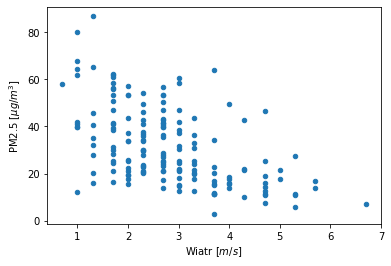

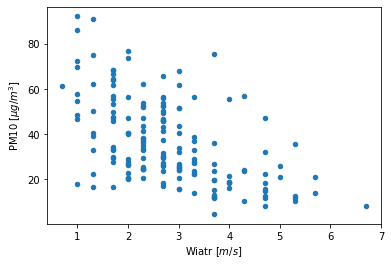

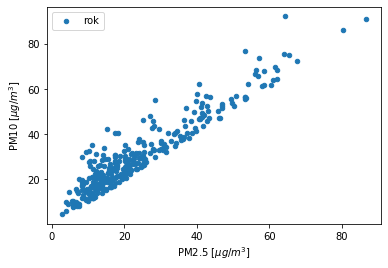

O3


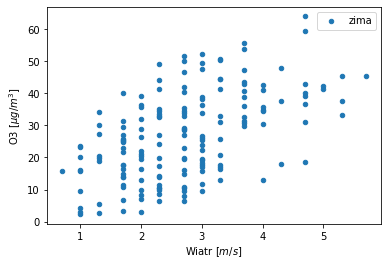

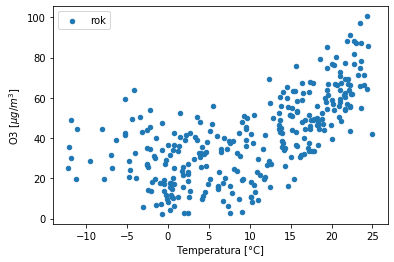

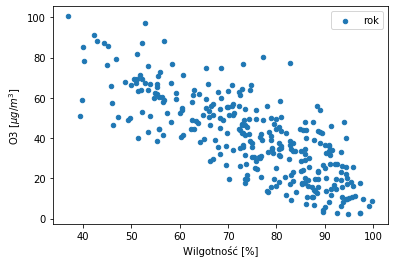

PM10 inne


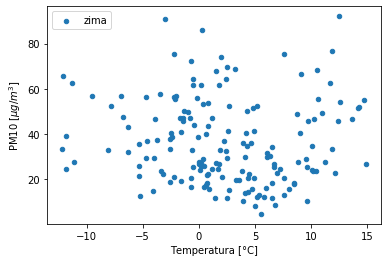

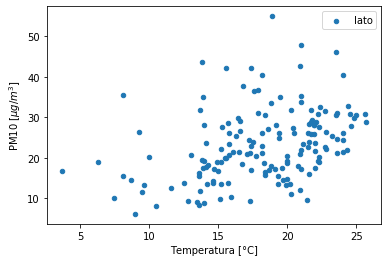

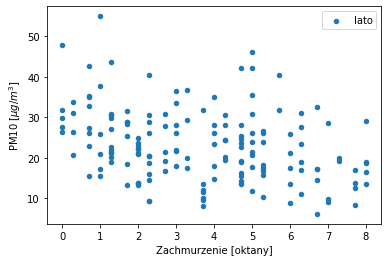

Inne


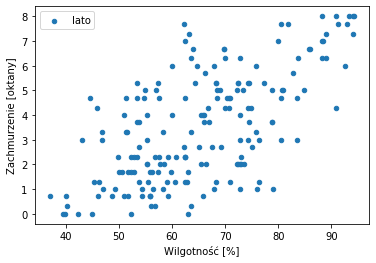

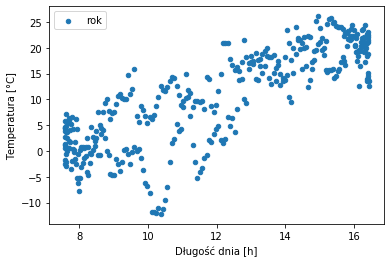

In [14]:
print("PM2.5/PM10 i wiatr")
plot_and_save(dane_zima, 'Wiatr', 'PM2.5', kind='scatter')
plot_and_save(dane_zima, 'Wiatr', 'PM10', kind='scatter')
plot_and_save(dane_rok, 'PM2.5', 'PM10', kind='scatter'
              , path='output/korelacje/PM10 vs PM2.5 (rok).png')
plt.show()


print("O3")
plot_and_save(dane_zima, 'Wiatr', 'O3', kind='scatter'
              , path='output/korelacje/O3 vs Wiatr (zima).png')
plot_and_save(dane_rok, 'Temperatura', 'O3', kind='scatter'
              , path='output/korelacje/O3 vs Temp (rok).png')
plot_and_save(dane_rok, 'Wilgotnosc', 'O3', kind='scatter'
              , path='output/korelacje/O3 vs Wilg (rok).png')
plt.show()


print("PM10 inne")
plot_and_save(dane_zima, 'Temperatura', 'PM10', kind='scatter'
              , path='output/korelacje/PM10 vs Temp (zima)-brak korel.png')
plot_and_save(dane_lato, 'Temperatura', 'PM10', kind='scatter'
              , path='output/korelacje/PM10 vs Temp (lato).png')
plot_and_save(dane_lato, 'Zachmurzenie', 'PM10', kind='scatter'
              , path='output/korelacje/PM10 vs Zachm (lato).png')
plt.show()


print("Inne")
plot_and_save(dane_lato, 'Wilgotnosc', 'Zachmurzenie', kind='scatter'
              , path='output/korelacje/Zachm vs Wilg (lato).png')
plot_and_save(dane_rok, 'Dlugosc_dnia', 'Temperatura', kind='scatter'
              , path='output/korelacje/Temp vs Dl_dnia (rok).png')
plt.show()

### Boxplot dla relacji: zanieczyszczenie PM2.5/PM10 a prędkość wiatru

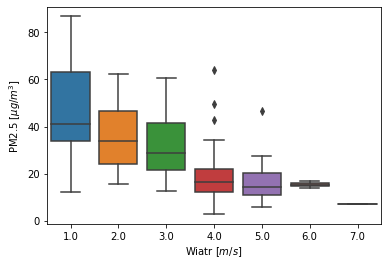

In [15]:
import seaborn as sns

dane_zima_ = dane_zima.copy()
dane_zima_['Wiatr'] = dane_zima['Wiatr'].map(lambda p: round(1*p) / 1.)


sns.boxplot(x = 'Wiatr', y = 'PM2.5', data=dane_zima_)
plt.xlabel('Wiatr $[m/s]$')
plt.ylabel('PM2.5 $[\mu g/m^3]$')
plt.savefig("output/PM2.5 vs Wiatr (zima).png")

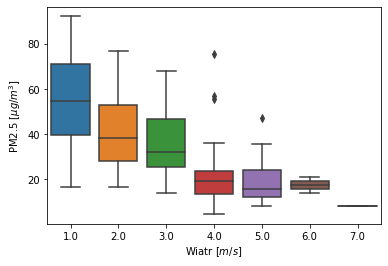

In [16]:
sns.boxplot( x = 'Wiatr', y = 'PM10', data=dane_zima_)
plt.xlabel('Wiatr $[m/s]$')
plt.ylabel('PM2.5 $[\mu g/m^3]$')
plt.savefig("output/PM10 vs Wiatr (zima).png")

### Wnioski
+ PM2.5 i PM10 <u>wyraźnie</u> zależą od prędkości wiatru w sposób hiperboliczny, ale ma to znaczenie tylko przy dużych stężeniach (zima).
+ PM10 w lecie zależy proporcjonalnie od temperatury, a odwrotnie proporcjonalnie od zachmurzenia. 
+ PM2.5 w lecie nie zależy ani od temperatury, ani od zachmurzenia.
+ Korelacja PM2.5 do P10 jest mniejsza w lecie, niz w zimie.
+ Zawartość O3 w lecie <u>wyraźnie</u> rośnie ze wzrostem temperatury i ze spadkiem wilgotności.
+ Zawartość O3 w zimie <u>wyraźnie</u> rośnie ze wzrostem predkości wiatru.
+ Zachmurzenie w lecie jest <u>wyraźnie</u> skorelowane z wilgotnością.